In [27]:
# 0. Import all libraries
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [28]:
import time
import psutil

# Record run time
start_time = time.time()

# Record cpu usage and memory usage
initial_cpu_usage = psutil.cpu_percent(interval=1)
initial_memory_info = psutil.virtual_memory()

In [29]:
# 1. Import data
# Close prices + Other prices + Volumes
file_path = './data/SMCI_merged.csv'
data = pd.read_csv(file_path)

In [30]:
# 2. Preparing Data
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data.sort_index(ascending=True)

columns_to_keep = ['Open', 'High', 'Low', 'Close/Last', 'Volume', 'DPRIME', 'VIX_Close']
data = data[columns_to_keep]

# Subset data for the specified date range
start_date = '2014-06-24'
end_date = '2024-06-21'
data = data[(data.index >= start_date) & (data.index <= end_date)]

In [31]:
# # Split data, method 1
# total_length = len(data)
# train_length = int(total_length * 0.80)
# train_set = data.iloc[:train_length].copy()
# valid_set = data.iloc[train_length:].copy()

# Split data, method 2
train_set = data[(data.index >= '2014-06-24') & (data.index < '2023-06-24')].copy()
valid_set = data[(data.index >= '2022-06-25') & (data.index <= '2024-06-21')].copy()

In [32]:
# Evaluate the importance of features

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler

X = data[['Open', 'High', 'Low', 'Volume', 'DPRIME', 'VIX_Close']].values
y = data['Close/Last'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X_scaled, y)
feature_scores = selector.scores_

for feature, score in zip(['Open', 'High', 'Low', 'Volume', 'DPRIME', 'VIX_Close'], feature_scores):
    print(f"Feature: {feature}, Score: {score}")

Feature: Open, Score: 716188.3813470071
Feature: High, Score: 1248429.3818496906
Feature: Low, Score: 2164461.9807615173
Feature: Volume, Score: 3269.5304888065248
Feature: DPRIME, Score: 1987.46731788726
Feature: VIX_Close, Score: 45.86508590417653


In [33]:
# 2. Setup Variables
# 2.1 Time horizon set to be 9 years for training, 1 year for validation
# 2.2 time steps for LSTM
time_steps = 60     # tested [30, 60, 90, 120], 90 is the most efficient one

# 2.3 Feature selection
selected_features = ['Close/Last', 'Volume', 'DPRIME', 'VIX_Close']

num_features = len(selected_features)

In [34]:
# 3. Data pre-processing

scalers = {}
train_data = train_set.copy()
valid_data = valid_set.copy()

for feature in selected_features:
    scalers[feature] = MinMaxScaler(feature_range=(0, 1))
    # scalers[feature] = StandardScaler()
    train_data[feature] = scalers[feature].fit_transform(train_set[feature].values.reshape(-1, 1))
    valid_data[feature] = scalers[feature].transform(valid_set[feature].values.reshape(-1, 1))

for feature in selected_features:
    scalers[feature] = MinMaxScaler(feature_range=(0, 1))
    train_data[feature] = scalers[feature].fit_transform(train_set[feature].values.reshape(-1, 1))
    valid_data[feature] = scalers[feature].transform(valid_set[feature].values.reshape(-1, 1))

# Initialize lists to store training and validation data
x_train, y_train = [], []
for i in range(time_steps, len(train_data)):
    x_train.append(train_data[selected_features].values[i-time_steps:i])
    y_train.append(train_data['Close/Last'].values[i])

x_valid, y_valid = [], []
for i in range(time_steps, len(valid_data)):
    x_valid.append(valid_data[selected_features].values[i-time_steps:i])
    y_valid.append(valid_data['Close/Last'].values[i])

# Convert lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_valid, y_valid = np.array(x_valid), np.array(y_valid)


In [35]:
# 4. Build Model - function
def build_model():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, num_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [36]:
# Training
model = build_model()
# history = model.fit(x_train, y_train, epochs=25, batch_size=32)
history = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_split=0.1, verbose=1)


predicted_y_valid_normalized = model.predict(x_valid)
predicted_y_valid = scalers['Close/Last'].inverse_transform(predicted_y_valid_normalized)


Epoch 1/25


/Users/beilinye/Desktop/Spring_2024/SYDE_660a/6_Code/stock-prediction/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 7.9672e-04 - val_loss: 0.0127
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 2.0868e-04 - val_loss: 0.0068
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.5541e-04 - val_loss: 0.0048
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.4161e-04 - val_loss: 0.0055
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.0171e-04 - val_loss: 0.0037
Epoch 6/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.1245e-04 - val_loss: 0.0027
Epoch 7/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.2923e-04 - val_loss: 0.0030
Epoch 8/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 9.0238e-05 - val_loss: 0.0025
Epoch 9/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 9.4569e-05 - val_loss: 0.0037
Epoch 10/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.4944e-05 - val_loss: 0.0022
Epoch 11/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.2168e-05 - val_loss: 0.0023
Epoch 12/25
63/63 ━━━━━━━━━━━━

LSTM RMSE on validation set: 59.54529583452848


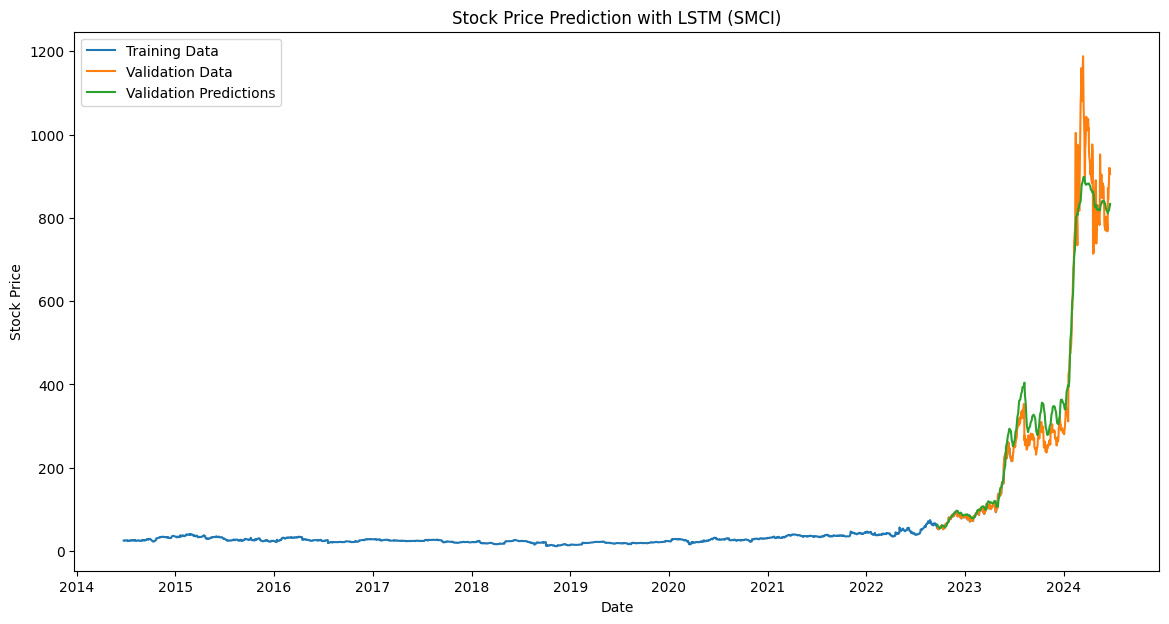

In [37]:
# Print & Visualize the results
valid_rmse = np.sqrt(mean_squared_error(valid_set['Close/Last'].values[time_steps:], predicted_y_valid))
print(f"LSTM RMSE on validation set: {valid_rmse}")

# Visualization
plt.figure(figsize=(14, 7))
plt.plot(train_set.index, train_set['Close/Last'], label='Training Data')
plt.plot(valid_set.index[time_steps:], valid_set['Close/Last'].values[time_steps:], label='Validation Data')
plt.plot(valid_set.index[time_steps:], predicted_y_valid, label='Validation Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction with LSTM (SMCI)')
plt.legend()
plt.show()

In [38]:
# CPU & memory
final_cpu_usage = psutil.cpu_percent(interval=1)
final_memory_info = psutil.virtual_memory()
cpu_usage_diff = round(final_cpu_usage - initial_cpu_usage, 2)
memory_usage_diff = round(final_memory_info.percent - initial_memory_info.percent, 2)

# Time
end_time = time.time()
total_time = round(end_time - start_time, 2)

print(f"CPU Usage: {cpu_usage_diff}%")
print(f"Memory Usage: {memory_usage_diff}%")
print(f"Total execution time: {total_time} seconds")

CPU Usage: 12.2%
Memory Usage: -0.2%
Total execution time: 40.03 seconds


In [39]:
# # Visualization of loss
# plt.figure(figsize=(14, 7))
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Loss during Training')
# plt.legend()
# plt.show()